## FBA simulation toy_atp
Simulating the FBA part.

In [1]:
from __future__ import print_function, absolute_import

import pandas as pd
import cobra
from matplotlib import pyplot as plt

from sbmlutils import fbc
from sbmlutils.dfba.analysis import set_matplotlib_parameters
from sbmlutils.dfba.toy_atp import model_factory

set_matplotlib_parameters()

In [2]:
# load model
sbml_path = './results/v{}/toy_atp_fba.xml'.format(model_factory.version)
print(sbml_path)
model = cobra.io.read_sbml_model(sbml_path)
cobra.io.sbml3.validate_sbml_model(sbml_path)

./results/v9/toy_atp_fba.xml


(<Model toy_atp_fba at 0x7fcfd8964828>,
 {'SBML errors': [], 'other': [], 'validator': [], 'warnings': []})

In [3]:
# objective function & boundaries
# pprint(mfba.objective)
df = fbc.cobra_reaction_info(model)
print(df)
print("reactions:", len(model.reactions))
print("metabolites:", len(model.metabolites))
print("genes:", len(model.genes))

          lb    ub reversibility boundary objective_coefficient  \
R1         0  1000         False    False                     0   
R2         0  1000         False    False                     0   
R3         0     1         False    False                     1   
EX_atp -1000  1000          True     True                     0   
EX_adp -1000  1000          True     True                     0   
EX_glc -1000  1000          True     True                     0   
EX_pyr -1000  1000          True     True                     0   

             forward_variable                     reverse_variable  
R1        0.0 <= R1 <= 1000.0           0 <= R1_reverse_cda52 <= 0  
R2        0.0 <= R2 <= 1000.0           0 <= R2_reverse_8c6d2 <= 0  
R3           0.0 <= R3 <= 1.0           0 <= R3_reverse_5c108 <= 0  
EX_atp  0 <= EX_atp <= 1000.0  0 <= EX_atp_reverse_dfd97 <= 1000.0  
EX_adp  0 <= EX_adp <= 1000.0  0 <= EX_adp_reverse_76b83 <= 1000.0  
EX_glc  0 <= EX_glc <= 1000.0  0 <= EX_glc_revers

In [4]:
# Exchange reactions
ex_idx = df.index.str.contains('^EX_')
df[ex_idx]

,lb,ub,reversibility,boundary,objective_coefficient,forward_variable,reverse_variable
EX_atp,-1000,1000,True,True,0,0 <= EX_atp <= 1000.0,0 <= EX_atp_reverse_dfd97 <= 1000.0
EX_adp,-1000,1000,True,True,0,0 <= EX_adp <= 1000.0,0 <= EX_adp_reverse_76b83 <= 1000.0
EX_glc,-1000,1000,True,True,0,0 <= EX_glc <= 1000.0,0 <= EX_glc_reverse_8e37d <= 1000.0
EX_pyr,-1000,1000,True,True,0,0 <= EX_pyr <= 1000.0,0 <= EX_pyr_reverse_03be5 <= 1000.0


In [5]:
# optimize
s = model.optimize(objective_sense="maximize")
model.summary(fva=True)

IN FLUXES                 OUT FLUXES             OBJECTIVES
------------------------  ---------------------  ------------
id      Flux  Range       id      Flux  Range    R3  1
----  ------  ----------  ----  ------  -------
adp      1    [1, 1]      atp        1  [1, 1]
glc      0.5  [0.5, 0.5]  pyr        1  [1, 1]


In [6]:
# pfba (minimal flux)
# no difference, the flux variability analysis 
# already showed us that the model has unique solution under given bounds 
s = model.optimize(objective_sense="maximize")
cobra.flux_analysis.pfba(model)
model.summary(fva=True)

IN FLUXES                 OUT FLUXES             OBJECTIVES
------------------------  ---------------------  ------------
id      Flux  Range       id      Flux  Range    R3  1
----  ------  ----------  ----  ------  -------
adp      1    [1, 1]      atp        1  [1, 1]
glc      0.5  [0.5, 0.5]  pyr        1  [1, 1]


In [7]:
s.fluxes

R1        0.5
R2        0.5
R3        1.0
EX_atp    1.0
EX_adp   -1.0
EX_glc   -0.5
EX_pyr    1.0
Name: fluxes, dtype: float64

In [8]:
print(model.objective)

Maximize
-1.0*R3_reverse_5c108 + 1.0*R3


## Check for uniquness of the solution
One possibility is to check via flux variability analysis. If the lower fluxes are identical to the upper fluxes the solution is unique.

### Flux variability analysis

In [9]:
from cobra.flux_analysis import flux_variability_analysis

In [10]:
fva = flux_variability_analysis(model)
fva

,maximum,minimum
EX_adp,-1.0,-1.0
EX_atp,1.0,1.0
EX_glc,-0.5,-0.5
EX_pyr,1.0,1.0
R1,0.5,0.5
R2,0.5,0.5
R3,1.0,1.0


In [11]:
import numpy as np
def fva_unique(fva, tol=1E-6):
    diff = np.sum(fva.maximum-fva.minimum)
    return (abs(diff)<tol)

fva_unique(fva)

True

### Flux sampling

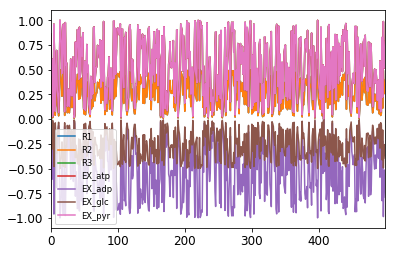

In [12]:
# This just samples the flux distributions which are possible,
# but not necessarily the optimal ones
from cobra.flux_analysis import sample
samples = sample(model, 500, processes=2)
samples.head()
samples.plot()
plt.show()

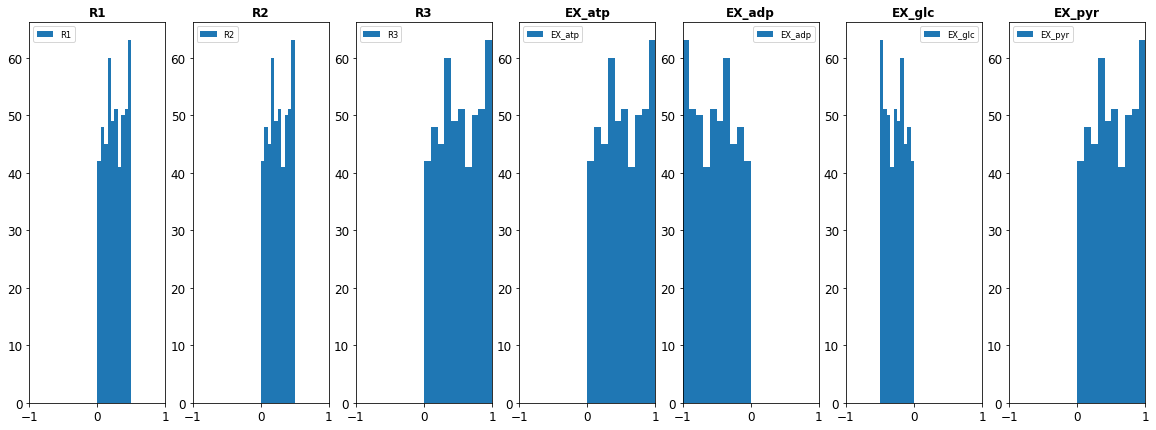

In [13]:
samples.head
fig, axes = plt.subplots(nrows=1, ncols=len(samples.columns), figsize=(20, 7))
for rid, ax in zip(samples.columns, axes):
    ax.hist(samples[rid], alpha=1.0, label=rid)
    ax.legend()
    ax.set_title(rid)
    ax.set_xlim(-1, 1)
plt.show()

Maximize
-1.0*R3_reverse_5c108 + 1.0*R3


cobra/flux_analysis/sampling.py:105 RuntimeWarning: divide by zero encountered in true_divide
cobra/flux_analysis/sampling.py:105 RuntimeWarning: divide by zero encountered in true_divide


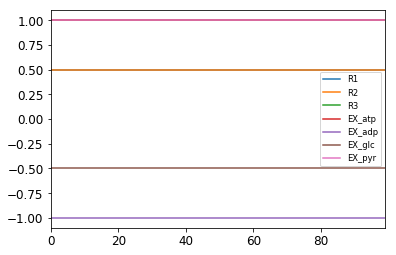

In [17]:
# necessary to add an additional constraint for optimality
print(model.objective)
with model as m:
    # add the objective value to the sampling
    co = model.problem.Constraint(model.reactions.R3.flux_expression, lb=1.0)
    model.add_cons_vars([co])
    samples = sample(model, 100, processes=2)
    samples.head()
    samples.plot()
    plt.show()